In [2]:
!wget https://raw.githubusercontent.com/bayodekehinde/Human-Action-Recognition-Based-Home-Automation/main/helper_function.py

--2023-05-29 09:56:28--  https://raw.githubusercontent.com/bayodekehinde/Human-Action-Recognition-Based-Home-Automation/main/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5254 (5.1K) [text/plain]
Saving to: ‘helper_function.py’

helper_function.py  100%[===================>]   5.13K  --.-KB/s    in 0s      

2023-05-29 09:56:28 (77.4 MB/s) - ‘helper_function.py’ saved [5254/5254]



In [3]:
from helper_function import load_zip_file, view_random_image,plot_loss_curves,plot_confusion_matrix

In [5]:
#Load dataset
load_zip_file("/content/drive/MyDrive/Dataset_with_100_examples.zip")



train_dir="/content/Dataset_with_100_examples/Train"
test_dir="/content/Dataset_with_100_examples/Test"


In [6]:
#preprocess data
IMG_SIZE=224,224


# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", #for binary classiification
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical", shuffle=False)

#get the class names

class_names=train_data.class_names
class_names

Found 382 files belonging to 5 classes.
Found 129 files belonging to 5 classes.


['clapping', 'lying', 'sitting', 'standing', 'waving']

'Image shape: (4160, 3120, 3)'

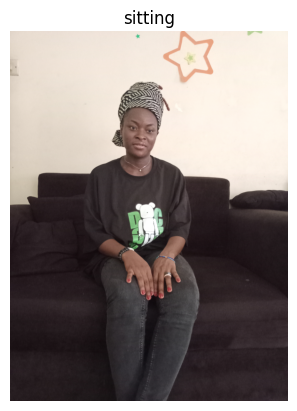

In [7]:


#visualize the data by viewing random images from the train set

#view the random images from the train dataset 

view_random_image(target_dir="/content/Dataset_with_100_examples/Train/", class_names=class_names)




In [8]:
#Build model using Functional API and compile model

#1. Create a model with tf.keras.applications

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

#4 Normalizing the inputs
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

x = base_model(x)
# Check data shape after passing it to base_model


# 5. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)


# 6. Create the output activation layer
outputs = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(x)

# 7. Combine the inputs with the outputs into a model
model_MobileNetv2 = tf.keras.Model(inputs, outputs)

# 8. Compile the model
model_MobileNetv2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 9. Fit the model (we use less steps for validation so it's faster)
history_MobileNetv2 = model_MobileNetv2.fit(train_data,
                                 epochs=10,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 
                                 validation_steps=len(test_data)
                                )

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
12/12 [==============================] - 59s 2s/step - loss: 1.2546 - accuracy: 0.5105 - val_loss: 0.8639 - val_accuracy: 0.6822
Epoch 2/10
12/12 [==============================] - 38s 1s/step - loss: 0.6422 - accuracy: 0.8298 - val_loss: 0.5148 - val_accuracy: 0.9147
Epoch 3/10
12/12 [==============================] - 39s 2s/step - loss: 0.4036 - accuracy: 0.9346 - val_loss: 0.3737 - val_accuracy: 0.9302
Epoch 4/10
12/12 [==============================] - 35s 1s/step - loss: 0.2908 - accuracy: 0.9555 - val_loss: 0.3060 - val_accuracy: 0.9380
Epoch 5/10
12/12 [==============================] - 37s 1s/step - loss: 0.2291 - accuracy: 0.9738 - val_loss: 0.2544 - val_accuracy: 0.9612
Epoch 6/10
12/12 [==============================] - 37s 2s/step - loss: 0.1822 - accuracy: 0.9764 - val_loss: 0.2227 - val_accuracy: 0.9767
Epoch 7/10
12/12 [==============================] - 35s 1s/step - loss: 0.1561 - accuracy: 0.9869

In [9]:
model_MobileNetv2.evaluate(test_data)

5/5 [==============================] - 12s 2s/step - loss: 0.1570 - accuracy: 0.9767


[0.15704861283302307, 0.9767441749572754]

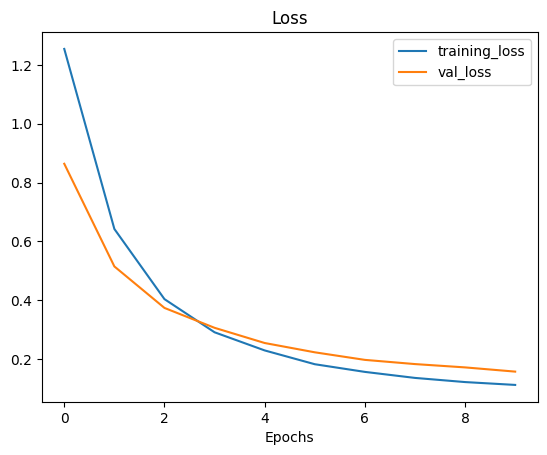

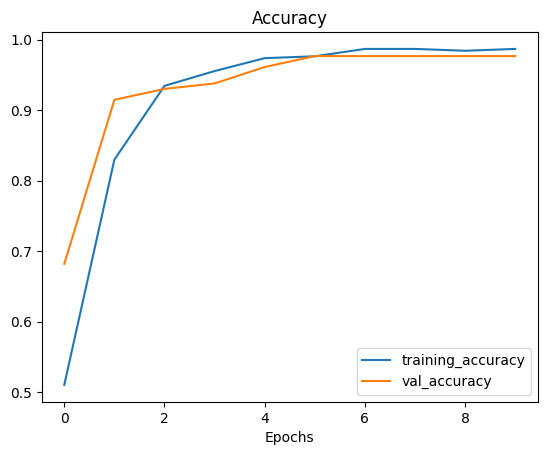

In [11]:
plot_loss_curves(history_MobileNetv2)

5/5 [==============================] - 11s 2s/step


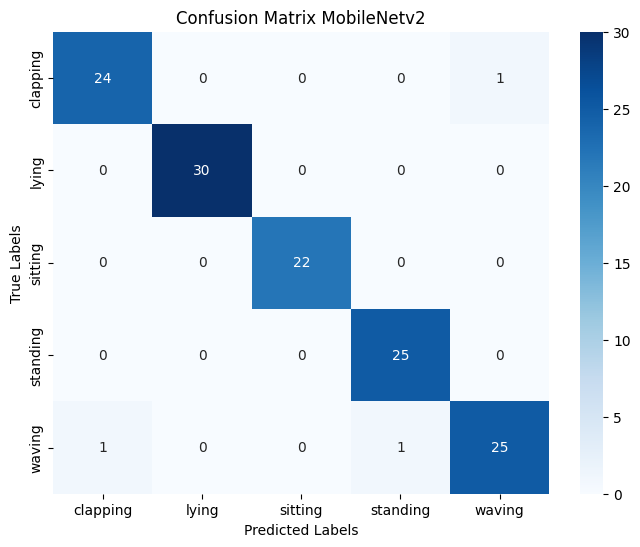

In [12]:
plot_confusion_matrix(trained_model=model_MobileNetv2, test_data=test_data,class_names=class_names, architecture_name="MobileNetv2")

In [ ]:
#save the model for use

model_MobileNetv2.save("Model_MobileNetv2.h5", history_MobileNetv2)